Jupyter notebook - Domestic Solar Energy Mexico CFE

## Project Description/Outline
#### We want to analyze the domestic solar energy  installation and usage (capacity  kW) in Mexico and compare it with (parameters such as radiation, growth or/and demand) and define a correlation.
#### Our framework consists in the analysis of the last 3 years (2017, 2018, 2019)  on the Mexican economic growth (ITAEE) or/and PIB VS  solar capacity (Kw).

## Dependencies

In [41]:
#Dependencies

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import requests
import random
import gmaps
import json
import os


# Import API key
from config import gkey
# Access maps with unique API key
gmaps.configure(api_key=gkey)
#import seaborn as sns; sns.set()

## Source Files

### + Dataframes creation

In [2]:
#Energy generaton by State from 2017 to 2019
df = pd.read_excel("Resources/Centraleselectricas-2.xlsx")
#df
#Growth indicator by State from 2017 to 2019
b = pd.read_excel("Resources/4_itaee_var_anual_retro2.xlsx")
#b
#Solar irradiation average by State
solar_irradiation= pd.read_excel("Resources/IrradiaciónSolar.xlsx")
#solar_irradiation.head()
#GNP (Gross National Product)
pib_df = pd.read_excel("Resources/PIBE_MX.xlsx")
#pib_df

## Data cleaning

In [3]:
#Clean Data Step 1
col=['No.','Número de identificación del proyecto asignado por el distribuidor','Nivel de tensión en el punto de interconexión'
, 'Número de fases','Área Administrativa del Distribuidor (Division)','Área Administrativa del Distribuidor (Zona)', 'Ubicación por circuito de distribución','Capacidad del circuito de distribución para albergar CE de GD',
    'Ubicación por subestación','Ubicación por Red de Distribución','Ubicación por NodoP','Regímen de contraprestación seleccionado','Estudio de interconexión requerido (Si/No)'
    ]
clean_df= df.drop(columns=col)
clean_df['year']=pd.DatetimeIndex(clean_df['Fecha de Interconexión Física']).year
clean_df_loc = clean_df.loc[clean_df["Estado en que se encuentra la solicitud: Recibida/Atendida/En lista de espera/Cancelada"] == "ATENDIDA"]
clean_df_loc = clean_df_loc.drop(columns = ["Estado en que se encuentra la solicitud: Recibida/Atendida/En lista de espera/Cancelada", "Fecha Solicitud", "Fecha de Interconexión Física", "Municipio"])
clean_df_gp = clean_df_loc.groupby(["year", "Estado", "Tecnología"]).sum()
#clean_df_gp

In [4]:
#Clean Data Step 2
clean_df_gp.reset_index(inplace = True)
clean_df_gp["Capacidad_kW_2017"] = clean_df_gp.loc[clean_df_gp.year == 2017,"Capacidad de la central eléctrica (kW)"]
clean_df_gp["Capacidad_kW_2018"] = clean_df_gp.loc[clean_df_gp.year == 2018,"Capacidad de la central eléctrica (kW)"]
clean_df_gp["Capacidad_kW_2019"] = clean_df_gp.loc[clean_df_gp.year == 2019,"Capacidad de la central eléctrica (kW)"]
#clean_df_gp

In [5]:
#Clean Data Step 3
clean_df_gp.loc[clean_df_gp['Capacidad_kW_2017'].isnull(), 'Capacidad_kW_2017'] = 0
clean_df_gp.loc[clean_df_gp['Capacidad_kW_2018'].isnull(), 'Capacidad_kW_2018'] = 0
clean_df_gp.loc[clean_df_gp['Capacidad_kW_2019'].isnull(), 'Capacidad_kW_2019'] = 0

clean_df_gp = clean_df_gp.groupby('Estado').sum()
clean_df_gp.drop(columns = "year", inplace=True)
clean_df_gp.reset_index(inplace = True)
#clean_df_gp.count()

In [14]:
#Clean Data Step 4
clean_state = b[["Estado","Crecimiento ITAEE 2017", "Crecimiento ITAEE 2018", "Crecimiento ITAEE 2019"]]
clean_state


,Estado,Crecimiento ITAEE 2017,Crecimiento ITAEE 2018,Crecimiento ITAEE 2019
0,Aguascalientes,2.459206,3.727672,-0.031717
1,Baja California,3.358687,2.284226,2.052373
2,Baja California Sur,10.708411,16.815057,-7.103514
3,Campeche,-10.446591,-1.422752,-2.153711
4,Coahuila de Zaragoza,5.444967,1.233570,0.171539
5,Colima,3.485108,2.503819,4.320531
6,Chiapas,-3.327992,-2.138943,-2.460577
7,Chihuahua,3.307919,1.956625,2.079865
8,Ciudad de México,3.001314,2.690299,-0.309418
9,Durango,-0.269926,1.451128,0.600691


In [97]:
#Clean Data Step 5
clean_state.rename(columns = {"Crecimiento ITAEE 2017":"Crecimiento_2017"
                              ,"Crecimiento ITAEE 2018":"Crecimiento_2018"
                               ,"Crecimiento ITAEE 2019":"Crecimiento_2019"},inplace= True)
#clean_state


/Users/jordanvillalobos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#Clean Data Step 6 *new PIB DF

pib_df.rename(columns={2017: "PIB_2017", 2018: "PIB_2018", 2019: "PIB_2019"},inplace=True)

pib_df["Estado"]=pib_df["Estado"].str.replace("Coahuila de Zaragoza","Coahuila")
pib_df["Estado"]=pib_df["Estado"].str.replace("México","Estado de México")
pib_df["Estado"]=pib_df["Estado"].str.replace("Michoacán de Ocampo","Michoacán")
pib_df["Estado"]=pib_df["Estado"].str.replace("Veracruz de Ignacio de la Llave","Veracruz")
#extra correction
pib_df["Estado"]=pib_df["Estado"].str.replace("Ciudad de Estado de México","Ciudad de México")


In [7]:
pib_df.count()
clean_df_gp.count()

Estado                                    32
Capacidad de la central eléctrica (kW)    32
Capacidad_kW_2017                         32
Capacidad_kW_2018                         32
Capacidad_kW_2019                         32
dtype: int64

In [100]:
clean_df_gp["Estado"].unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Ciudad de México', 'Coahuila',
       'Colima', 'Durango', 'Estado de México', 'Guanajuato', 'Guerrero',
       'Hidalgo', 'Jalisco', 'Michoacán', 'Morelos', 'Nayarit',
       'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo',
       'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz', 'Yucatán', 'Zacatecas'], dtype=object)

In [10]:
pib_df["Estado"].unique()
df["Estado"].unique()
clean_df_gp

,Estado,Capacidad de la central eléctrica (kW),Capacidad_kW_2017,Capacidad_kW_2018,Capacidad_kW_2019
0,Aguascalientes,12519.23,5322.08,3963.01,3234.14
1,Baja California,18114.67,5689.40,9425.13,3000.14
2,Baja California Sur,6770.02,2853.31,3393.81,522.90
3,Campeche,3583.71,998.20,2389.27,196.24
4,Chiapas,3296.86,1644.83,1257.89,394.14
5,Chihuahua,40649.46,13138.94,15826.16,11684.36
6,Ciudad de México,57968.76,25371.71,29826.01,2771.04
7,Coahuila,21595.53,7789.15,7871.55,5934.83
8,Colima,7672.50,3017.00,3179.64,1475.86
9,Durango,8733.43,2462.20,2931.02,3340.21


In [11]:
solar_irradiation["Estado.1"].unique()

array(['Aguascalientes', 'Baja California Sur', 'Baja California',
       'Campeche', 'Chiapas', 'Chihuahua', 'Coahuila', 'Colima', 'D.F.',
       'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco',
       'Mexico', 'Michoacan', 'Nayarit', 'Nuevo Leon', 'Oaxaca', 'Puebla',
       'Queretaro', 'Quintana Roo', 'San Luis Potosi', 'Sinaloa',
       'Sonora', 'Tamaulipas', 'Tlaxcala', 'Veracruz', 'Yucatan',
       'Zacatecas'], dtype=object)

In [17]:
#Merge Data Step 1
merge_df = pd.merge(clean_df_gp, clean_state, how = "inner", on = "Estado")
group_df = merge_df.groupby("Estado").sum()

#Update now merging with PIB DF
merge_df = pd.merge(clean_df_gp, pib_df, how = "inner", on = "Estado")
merge_df


,Capacidad de la central eléctrica (kW),Capacidad_kW_2017,Capacidad_kW_2018,Capacidad_kW_2019,Crecimiento ITAEE 2017,Crecimiento ITAEE 2018,Crecimiento ITAEE 2019
Estado,,,,,,,
Aguascalientes,12519.23,5322.08,3963.01,3234.14,2.459206,3.727672,-0.031717
Baja California,18114.67,5689.40,9425.13,3000.14,3.358687,2.284226,2.052373
Baja California Sur,6770.02,2853.31,3393.81,522.90,10.708411,16.815057,-7.103514
Campeche,3583.71,998.20,2389.27,196.24,-10.446591,-1.422752,-2.153711
Chiapas,3296.86,1644.83,1257.89,394.14,-3.327992,-2.138943,-2.460577
Chihuahua,40649.46,13138.94,15826.16,11684.36,3.307919,1.956625,2.079865
Ciudad de México,57968.76,25371.71,29826.01,2771.04,3.001314,2.690299,-0.309418
Colima,7672.50,3017.00,3179.64,1475.86,3.485108,2.503819,4.320531
Durango,8733.43,2462.20,2931.02,3340.21,-0.269926,1.451128,0.600691


In [21]:
#Clean Data Step 7
solar_irradiation_clean=solar_irradiation.drop(columns=["Estado"])
#solar_irradiation_clean
solar_irradiation_clean=solar_irradiation_clean.rename(columns={"Estado.1":"Estado"})
solar_irradiation_clean["Estado"]=solar_irradiation_clean["Estado"].str.replace("Yucatan","Yucatán")
solar_irradiation_clean["Estado"]=solar_irradiation_clean["Estado"].str.replace("Nuevo Leon","Nuevo León")
##
solar_irradiation_clean["Estado"]=solar_irradiation_clean["Estado"].str.replace("D.F.","Ciudad de México")
solar_irradiation_clean["Estado"]=solar_irradiation_clean["Estado"].str.replace("San Luis Potosi","San Luis Potosí")
solar_irradiation_clean["Estado"]=solar_irradiation_clean["Estado"].str.replace("Mexico","Estado de México")
solar_irradiation_clean["Estado"]=solar_irradiation_clean["Estado"].str.replace("Michoacan","Michoacán")
solar_irradiation_clean["Estado"]=solar_irradiation_clean["Estado"].str.replace("Queretaro","Querétaro")

##
# solar_irradiation_clean


In [20]:
avg_solar=solar_irradiation_clean.drop(columns=["Ciudad","Ene","Feb","Mar","Abr","May","Jun","Jul","Agos","Sept","Oct","Nov","Dic","Min","Max"])

#solar_irradiation_clean.groupby("Estado").sum()
solar_irradiaton_df = avg_solar.groupby("Estado").mean()
solar_irradiaton_df.reset_index(inplace = True)
solar_irradiaton_df
avg_solar




,Estado,Medida
0,Aguascalientes,5.6
1,Baja California Sur,6.6
2,Baja California,5.5
3,Baja California,5.5
4,Baja California Sur,5.7
5,Campeche,5.2
6,Chiapas,5.4
7,Chiapas,4.5
8,Chiapas,4.5
9,Chiapas,4.7


In [22]:
#Merge Data Step 2
grouped_df=pd.merge(merge_df,solar_irradiaton_df,how="left",on="Estado")
grouped_df.rename(columns = {"Medida":"Radiacion"},inplace= True)
grouped_df.loc[grouped_df['Radiacion'].isnull(), 'Radiacion'] = 0
grouped_df

,Estado,Capacidad de la central eléctrica (kW),Capacidad_kW_2017,Capacidad_kW_2018,Capacidad_kW_2019,PIB_2017,PIB_2018,PIB_2019,Radiacion
0,Aguascalientes,12519.23,5322.08,3963.01,3234.14,211672.469,216705.560,224807.469,5.600000
1,Baja California,18114.67,5689.40,9425.13,3000.14,535552.651,553327.213,565895.378,5.500000
2,Baja California Sur,6770.02,2853.31,3393.81,522.90,133948.675,148376.630,173047.360,6.150000
3,Campeche,3583.71,998.20,2389.27,196.24,600612.272,537882.577,529584.304,5.200000
4,Chiapas,3296.86,1644.83,1257.89,394.14,287034.269,277580.835,271621.449,4.760000
5,Chihuahua,40649.46,13138.94,15826.16,11684.36,534205.546,551497.303,562599.228,6.333333
6,Ciudad de México,57968.76,25371.71,29826.01,2771.04,2957233.594,3045539.859,3128247.710,5.300000
7,Colima,7672.50,3017.00,3179.64,1475.86,98576.211,102039.429,104474.901,4.900000
8,Durango,8733.43,2462.20,2931.02,3340.21,200660.962,199559.310,202546.990,5.700000
9,Estado de México,25654.47,11657.07,11285.31,2712.09,1485467.443,1556925.971,1605830.823,5.100000


## Data Analysis 1
### Plots and Linear Regression with ITAAE

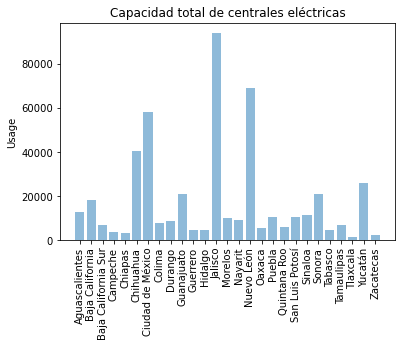

In [23]:
group_df = group_df.reset_index()
y_pos = np.arange(len(group_df))
plt.bar(y_pos, group_df['Capacidad de la central eléctrica (kW)'], align='center', alpha=0.5)
plt.xticks(y_pos, group_df['Estado'], rotation = 90)
plt.ylabel('Usage')
plt.title('Capacidad total de centrales eléctricas')
x = group_df.sort_values(by=['Capacidad de la central eléctrica (kW)'], ascending=False)
x[['Estado','Capacidad de la central eléctrica (kW)']].reset_index(drop=True,).head(5)
plt.savefig("Capacidad total de centrales eléctricas")

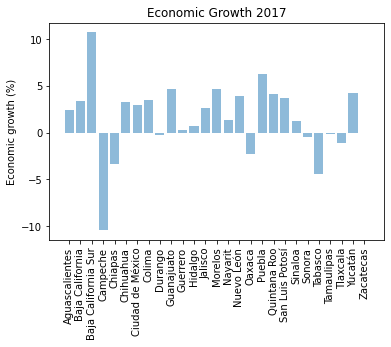

In [29]:
y_pos = np.arange(len(group_df))
plt.bar(y_pos, group_df['Crecimiento ITAEE 2017'], align='center', alpha=0.5)
plt.xticks(y_pos, group_df['Estado'], rotation = 90)
plt.ylabel('Economic growth (%)')
plt.title('Economic Growth 2017')
x = group_df.sort_values(by=['Crecimiento ITAEE 2017'], ascending=False)
x[['Estado','Crecimiento ITAEE 2017']].reset_index(drop=True,).head(5)
plt.savefig("Economic Growth 2017")

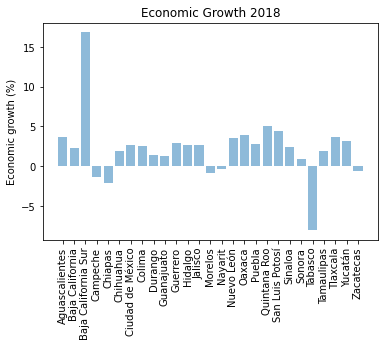

In [30]:
y_pos = np.arange(len(group_df))
plt.bar(y_pos, group_df['Crecimiento ITAEE 2018'], align='center', alpha=0.5)
plt.xticks(y_pos, group_df['Estado'], rotation = 90)
plt.ylabel('Economic growth (%)')
plt.title('Economic Growth 2018')
x = group_df.sort_values(by=['Crecimiento ITAEE 2018'], ascending=False)
x[['Estado','Crecimiento ITAEE 2018']].head(5)
plt.savefig("Economic Growth 2018")

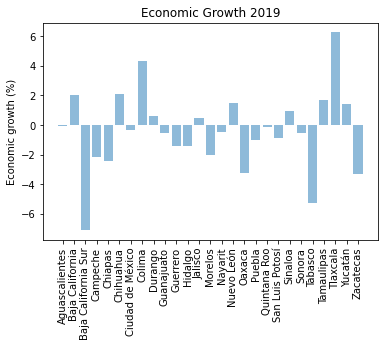

In [31]:
y_pos = np.arange(len(group_df))
plt.bar(y_pos, group_df['Crecimiento ITAEE 2019'], align='center', alpha=0.5)
plt.xticks(y_pos, group_df['Estado'], rotation = 90)
plt.ylabel('Economic growth (%)')
plt.title('Economic Growth 2019')
x = group_df.sort_values(by=['Crecimiento ITAEE 2019'], ascending=False)
x[['Estado','Crecimiento ITAEE 2019']].reset_index(drop=True,).head(5)
plt.savefig("Economic Growth 2019")

In [32]:
import scipy.stats as st
from scipy.stats import linregress

The correlation between both factors is 0.3


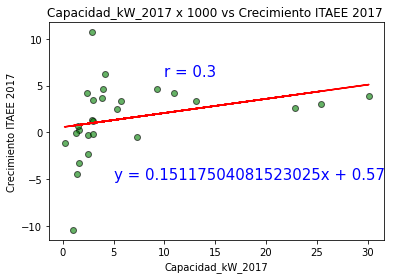

The correlation between both factors is 0.07


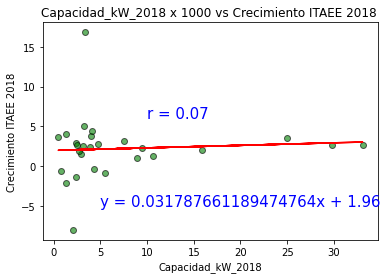

The correlation between both factors is 0.21


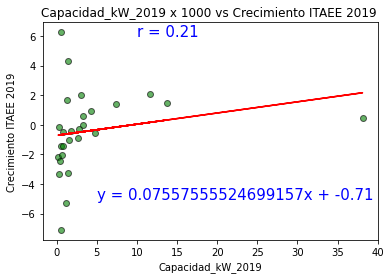

In [33]:
w = 2
e = 5
while w < 5:
    x_values = group_df.iloc[:,w]/1000
    y_values = group_df.iloc[:,e]
    correlation = st.pearsonr(x_values,y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(slope) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values,marker="o",facecolors="green", edgecolors="black", alpha=0.60)
    plt.title(f'{group_df.columns[w]} x 1000 vs {group_df.columns[e]} ')
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(5,-5),fontsize=15,color="blue")
    plt.annotate(f"r = {round(correlation[0],2)}", (10,6),fontsize=15,color="blue")
    plt.xlabel(group_df.columns[w])
    plt.ylabel(group_df.columns[e])
    plt.savefig(f'{group_df.columns[w]} x 1000 vs {group_df.columns[e]} ')
    plt.show()
    w = w+1
    e = e+1

The correlation between both factors is 0.78


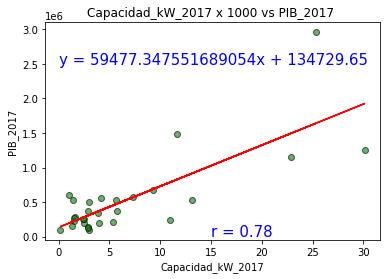

The correlation between both factors is 0.8


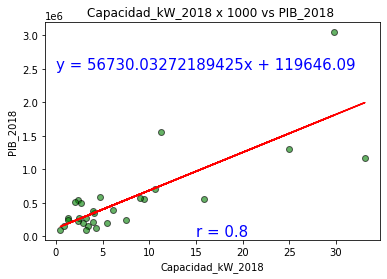

The correlation between both factors is 0.3


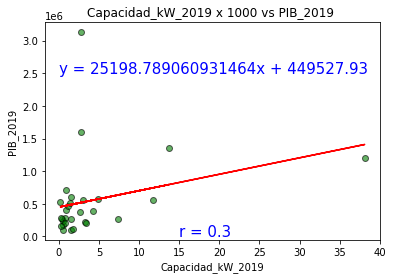

In [34]:
w = 2
e = 5
while w < 5:
    x_values = grouped_df.iloc[:,w]/1000
    y_values = grouped_df.iloc[:,e]
    correlation = st.pearsonr(x_values,y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(slope) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values,marker="o",facecolors="green", edgecolors="black", alpha=0.60)
    plt.title(f'{grouped_df.columns[w]} x 1000 vs {grouped_df.columns[e]} ')
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(0,2500000),fontsize=15,color="blue")
    plt.annotate(f"r = {round(correlation[0],2)}", (15,10),fontsize=15,color="blue")
    plt.xlabel(grouped_df.columns[w])
    plt.ylabel(grouped_df.columns[e])
    plt.savefig(f'{grouped_df.columns[w]} x 1000 vs {grouped_df.columns[e]} ')
    plt.show()
    w = w+1
    e = e+1

## Data Analysis 2
### Plots and linear regressión with PIB

In [35]:
capacity_df = grouped_df[["Estado", "Capacidad_kW_2017", "Capacidad_kW_2018", "Capacidad_kW_2019"]]
#capacity_df
top_capacity = capacity_df.nlargest(5, ["Capacidad_kW_2017", "Capacidad_kW_2018", "Capacidad_kW_2019"])
top_capacity

,Estado,Capacidad_kW_2017,Capacidad_kW_2018,Capacidad_kW_2019
16,Nuevo León,30132.53,25016.08,13726.16
6,Ciudad de México,25371.71,29826.01,2771.04
13,Jalisco,22844.92,33073.05,38105.81
5,Chihuahua,13138.94,15826.16,11684.36
9,Estado de México,11657.07,11285.31,2712.09


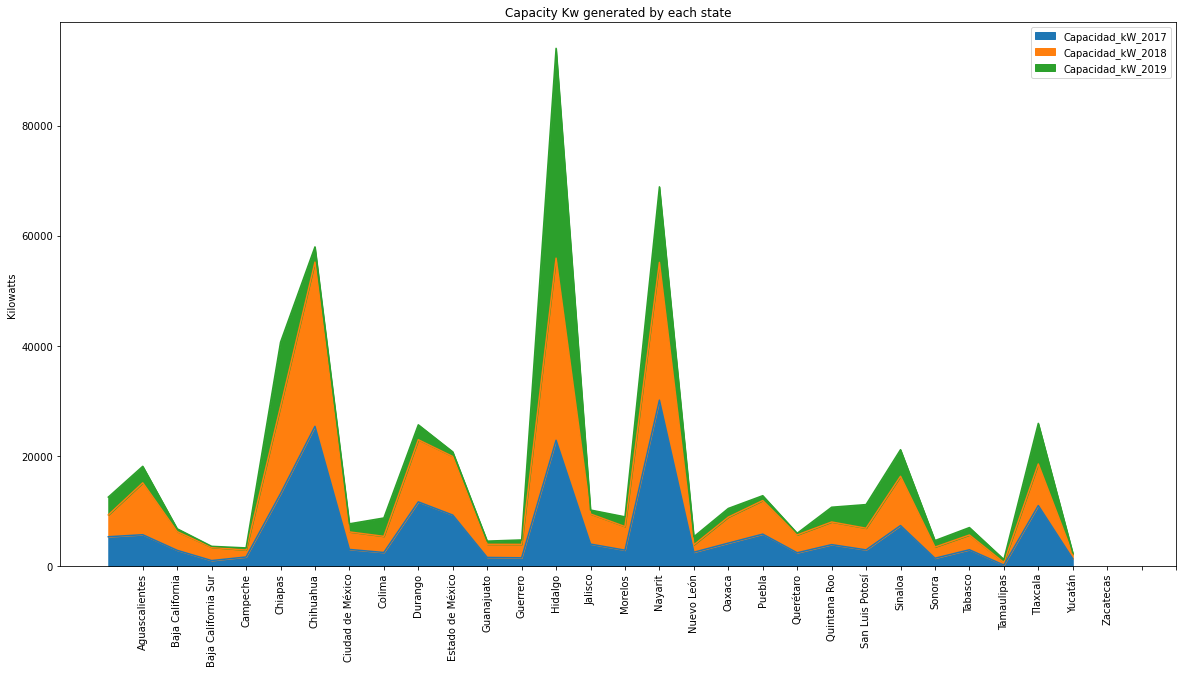

In [36]:
#Area plot to show growth
ax = capacity_df.plot.area(figsize=(20,10))

ax.set_title("Capacity Kw generated by each state")
ax.set_xticklabels(capacity_df.Estado,rotation=90, minor=False)
ax.set_xticks(range(1,32)) 
ax.set_ylabel("Kilowatts")
ax

In [37]:
top_PIBE = pib_df.nlargest(5, ["PIB_2017", "PIB_2018", "PIB_2019"])
top_PIBE

,Estado,PIB_2017,PIB_2018,PIB_2019
8,Ciudad de México,2957233.594,3045539.859,3128247.710
14,Estado de México,1485467.443,1556925.971,1605830.823
18,Nuevo León,1257648.421,1306549.097,1353874.513
13,Jalisco,1149129.548,1176616.034,1207897.462
29,Veracruz,784930.108,776072.856,794376.310


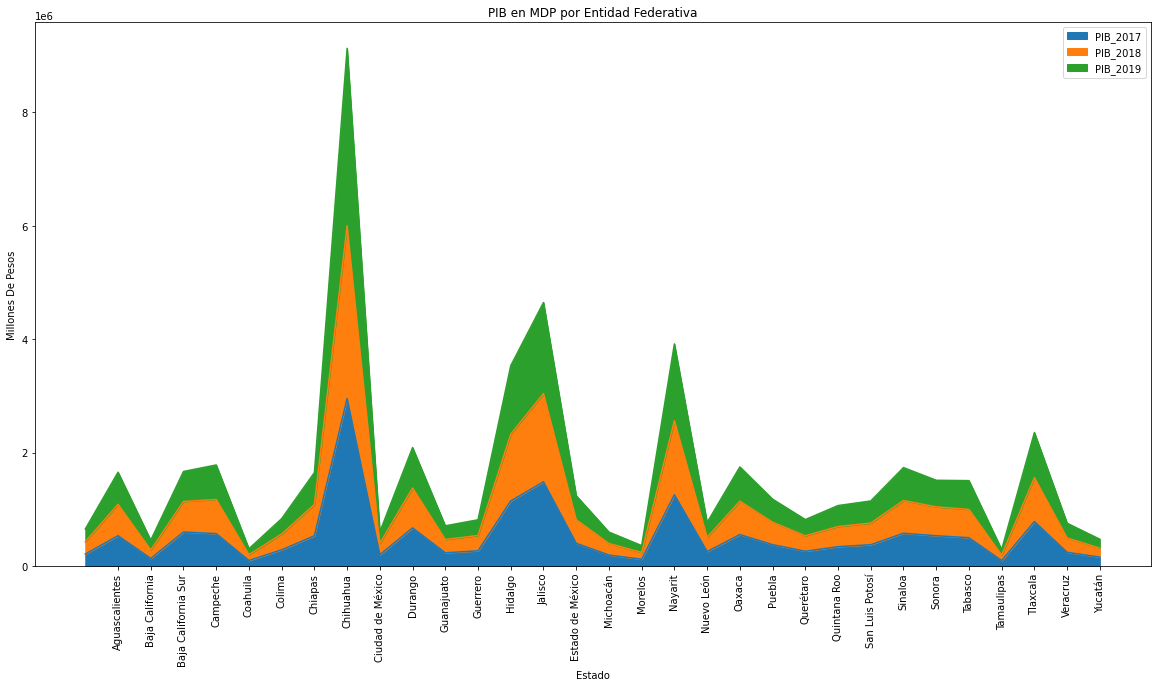

In [38]:
plt = pib_df.plot.area(figsize=(20,10))

plt.set_title('PIB en MDP por Entidad Federativa')
plt.set_xlabel('Estado')
plt.set_ylabel('Millones De Pesos')
plt.set_xticklabels(pib_df.Estado,rotation=90, )
plt.set_xticks(range(1,32)) 
# Show graphic
plt
# Save plot
#plt.savefig("Output Data/PIB en MDP vs. año")


## API Google maps requests

### Getting Latitude and Longitud for each State

In [42]:
grouped_df['Lat'] = ""
grouped_df['Lng'] = ""
#group_df.reset_index(inplace = True)
#group_df
#for index, row in group_df.iterrows():
# create a params dict that will be updated with new city each iteration
params = {"key": gkey}

# Loop through the cities_pd and run a lat/long search for each city
for index, row in grouped_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    state = row['Estado']

    # update address key value
    params['address'] = f"{state},Mexico"

    # make request
    states_lat_lng = requests.get(base_url, params=params)
    
        
    # convert to json
    states_lat_lng = states_lat_lng.json()

    grouped_df.loc[index, "Lat"] = states_lat_lng["results"][0]["geometry"]["location"]["lat"]
    grouped_df.loc[index, "Lng"] = states_lat_lng["results"][0]["geometry"]["location"]["lng"]

# Visualize to confirm lat lng appear
grouped_df
#  

,Estado,Capacidad de la central eléctrica (kW),Capacidad_kW_2017,Capacidad_kW_2018,Capacidad_kW_2019,PIB_2017,PIB_2018,PIB_2019,Radiacion,Lat,Lng
0,Aguascalientes,12519.23,5322.08,3963.01,3234.14,211672.469,216705.560,224807.469,5.600000,21.8853,-102.292
1,Baja California,18114.67,5689.40,9425.13,3000.14,535552.651,553327.213,565895.378,5.500000,30.8406,-115.284
2,Baja California Sur,6770.02,2853.31,3393.81,522.90,133948.675,148376.630,173047.360,6.150000,26.0444,-111.666
3,Campeche,3583.71,998.20,2389.27,196.24,600612.272,537882.577,529584.304,5.200000,19.8301,-90.5349
4,Chiapas,3296.86,1644.83,1257.89,394.14,287034.269,277580.835,271621.449,4.760000,16.7569,-93.1292
5,Chihuahua,40649.46,13138.94,15826.16,11684.36,534205.546,551497.303,562599.228,6.333333,28.633,-106.069
6,Ciudad de México,57968.76,25371.71,29826.01,2771.04,2957233.594,3045539.859,3128247.710,5.300000,19.4326,-99.1332
7,Colima,7672.50,3017.00,3179.64,1475.86,98576.211,102039.429,104474.901,4.900000,19.2452,-103.724
8,Durango,8733.43,2462.20,2931.02,3340.21,200660.962,199559.310,202546.990,5.700000,24.0277,-104.653
9,Estado de México,25654.47,11657.07,11285.31,2712.09,1485467.443,1556925.971,1605830.823,5.100000,19.4969,-99.7233


## Heatmap showing Total electric capacity for State

In [43]:
# Store 'Lat' and 'Lng' into  locations 
locations = grouped_df[["Lat", "Lng"]].astype(float)
capacidad_instalada = grouped_df["Capacidad de la central eléctrica (kW)"].astype(float)

print(len(locations),len(capacidad_instalada))
# Create a Humidity layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=capacidad_instalada/1000, 
                                 dissipating=False, max_intensity=10,
                                 point_radius = .5)

fig.add_layer(heat_layer)


fig

29 29


Figure(layout=FigureLayout(height='420px'))

In [44]:
info_box_template = """
<dl>
<dt>State</dt><dd>{Estado}</dd>
<dt>Electric capactiy (Kw)</dt><dd>{Capacidad_kW_2019}</dd>
<dt>PIB (MDP) $</dt><dd>{PIB_2019}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
analysis_info = [info_box_template.format(**row) for index, row in grouped_df.iterrows()]

In [45]:
# Create PIB symbol layer
PIB_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content= analysis_info
)


fig = gmaps.figure()
fig.add_layer(PIB_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [46]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(PIB_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Heatmap showing average solar radiation for State

In [47]:
# Store 'Lat' and 'Lng' into  locations 
locations = grouped_df[["Lat", "Lng"]].astype(float)
actividad_solar = grouped_df["Radiacion"].astype(float)

print(len(locations),len(actividad_solar))
# Create a Humidity layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=actividad_solar, 
                                 dissipating=False, max_intensity=10,
                                 point_radius = 2
                                )
heat_layer.gradient = [ 'blue','red']
fig.add_layer(heat_layer)


fig

29 29


Figure(layout=FigureLayout(height='420px'))

## Conclusions
### After mining , cleaning and organizing the data for the “Domestic solar energy  usage in Mexico” and the “PIB by each sate” . We conclude and confirm our hypothesis; 

## The richer a state is the more domestic solar panels are installed, active and generating solar energy capacity (kW) for CFE in Mexico.

### When testing, contrasting and comparing data:  The top 5 state df analysis,  we found out that Nuevo León, Ciudad de Mexico, Jalisco and Estado de México had a correlation (not in the same order) with the top 5 states that generated more PIB in Mexico. Moreover we also observed that Chihuahua that is the 4th in the top 5 state generating solar energy (kW),  is among the last states that generates PIB for Mexico. Vice-versa, Veracruz is the 5th state generating PIB in Mexico but has a really low amount of domestic solar panels working. This indicates that 1 out of 5 states are not governed by thes same rule of ourconfirm hypothesis (richer states have more solar panels).